In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from rdkit import Chem
from pathlib import Path
import torch 
from collections import namedtuple
from copy import deepcopy
import os
import numpy as np

from e3mol.experiments.data.datainfo import load_dataset_info
from e3mol.experiments.data.dataset import LigandPocketDataModule as DataModule
from e3mol.experiments.data.fragmentation import FragmentTransform

In [3]:
def check_for_disconnected_components(rdmol):
    mol_frags = Chem.rdmolops.GetMolFrags(
                        rdmol, asMols=True, sanitizeFrags=False
                    )
    return len(mol_frags) < 2

In [4]:
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.molSize = (400, 400)   # Change image size
IPythonConsole.ipython_useSVG = True  # Change output to SVG
IPythonConsole.ipython_maxProperties = 0

In [22]:
from e3mol.experiments.data.mol_vis import show_atom_number, visualize_multiple_3d_mols, view_3d

## Download

Please download model weights from the kinodata3d model here: https://figshare.com/articles/dataset/Checkpoints_to_lightning_model/30739268?file=59948612

The paths will decompress into 
```
ckpts/
└── kinodata3d/
    ├── diffusion/
    ├── flow/
    │   ├── recap/
    │   ├── brics/
    │   └── cutable/
    │       └── best_valid.ckpt
```

-----

Dataset for loading statistics can be downloaded here: https://figshare.com/articles/dataset/Datasets_including_CrossDocked2020_and_KinoData-3D/30739232?file=59947856

Choose the kinodata3d folder as `datapath`

In [ ]:
bp = Path("./ckpt/kinodata3d/flow/cutable/")
datapath = Path("./data/kinodata3d/")
path = bp / "best_valid.ckpt"

## Use PILOT-Flow Model

In [11]:
ckpt = torch.load(path, map_location="cpu")
hparams = torch.load(path, map_location="cpu")["hyper_parameters"]
hparams = namedtuple("hparams", hparams.keys())(*hparams.values())
hparams = hparams._replace(batch_size=1)
hparams = hparams._replace(dataset_root=str(datapath))

In [13]:
transform = FragmentTransform(minFragmentSize=6, method="briccs-recap")
datamodule = DataModule(hparams, transform=transform)
datamodule.setup()
statistics_dict_path = hparams.dataset_root + "/processed/all_stats_dict_noh.pickle"
dataset_info = load_dataset_info(
    name=hparams.dataset,
    statistics_dict_path=statistics_dict_path,
    ligand_pocket_histogram_path=None,
)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [15]:
from e3mol.experiments.trainer import TrainerFlow as Trainer
from e3mol.experiments.sampling.inpaint_ligands_multi import create_batch_from_pl_files

model = Trainer.load_from_checkpoint(path,
                                     dataset_info=dataset_info,
                                     pocket_noise_std=hparams.pocket_noise_std,
                                     ckpt_path=None,
                                     smiles=datamodule.train_dataset.smiles,
                                    ).to(device)
model.smiles_train = datamodule.train_dataset.smiles

Using Protein-Ligand Flow Model


In [16]:
root_path = datapath / "test"
sdf_files = sorted(list(root_path.glob("[!.]*.sdf")))
pdb_files = sorted(list(root_path.glob("[!.]*.pdb")))

In [18]:
sdf_file = sdf_files[0]
pdb_file = pdb_files[0]

mol = Chem.SDMolSupplier(str(sdf_file), sanitize=True, removeHs=True)[0]
mol.RemoveAllConformers()
for prop in mol.GetPropNames():
    mol.ClearProp(prop)

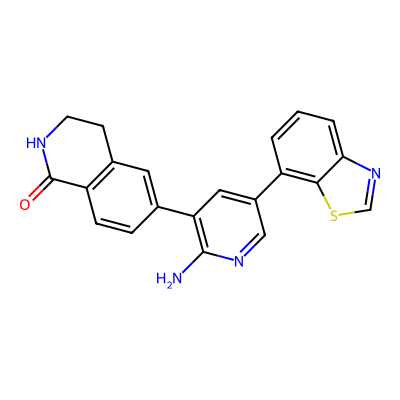

In [19]:
mol

## De-Novo Generation

In [20]:
do_inpainting = False

data = create_batch_from_pl_files(
                pdb_file=pdb_file,
                sdf_file=sdf_file,
                batch_size=32,
                pocket_cutoff=5.0,
                removeHs_ligand_post=True,
                removeHs_pocket_post=True,
                inpainting=do_inpainting,
                keep_ids=None,
                anchor_idx=None,
                min_nodes_bias=0,
                max_nodes_bias=0,
            ).to(device)

num_nodes_lig = torch.randint(low=mol.GetNumHeavyAtoms() - 5,
                              high=mol.GetNumHeavyAtoms() + 5, 
                              size=(32, ),
                              device=device
                              )
gen_mols = []
num_graphs = len(data.batch.bincount())
with torch.no_grad():
    molecules, traj, cl_loss = model.model.reverse_sampling(
        N=100,
        num_graphs=num_graphs,
        num_nodes_lig=num_nodes_lig,
        device=model.device,
        pocket_data=data,
        verbose=True,
        save_traj=True,
        cat_noise=True,
        pos_noise=False,
        clash_guidance=False,
        clash_guidance_scale=0.05,
        score_dynamics=True,
        score_scale=0.5,
        dt_pow=0.5,
    )
rdmols = [m.rdkit_mol for m in molecules]
is_valid = []
for i, mol in enumerate(rdmols):
    try:
        Chem.SanitizeMol(mol)
        if check_for_disconnected_components(mol):
            is_valid.append(i)
    except: 
        pass
rdmols_valid = [rdmols[i] for i in is_valid]
gen_mols.extend(rdmols_valid)

100%|██████████| 100/100 [00:14<00:00,  6.93it/s]
[10:05:46] Explicit valence for atom # 0 N, 4, is greater than permitted


In [23]:
view_3d(gen_mols[1])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

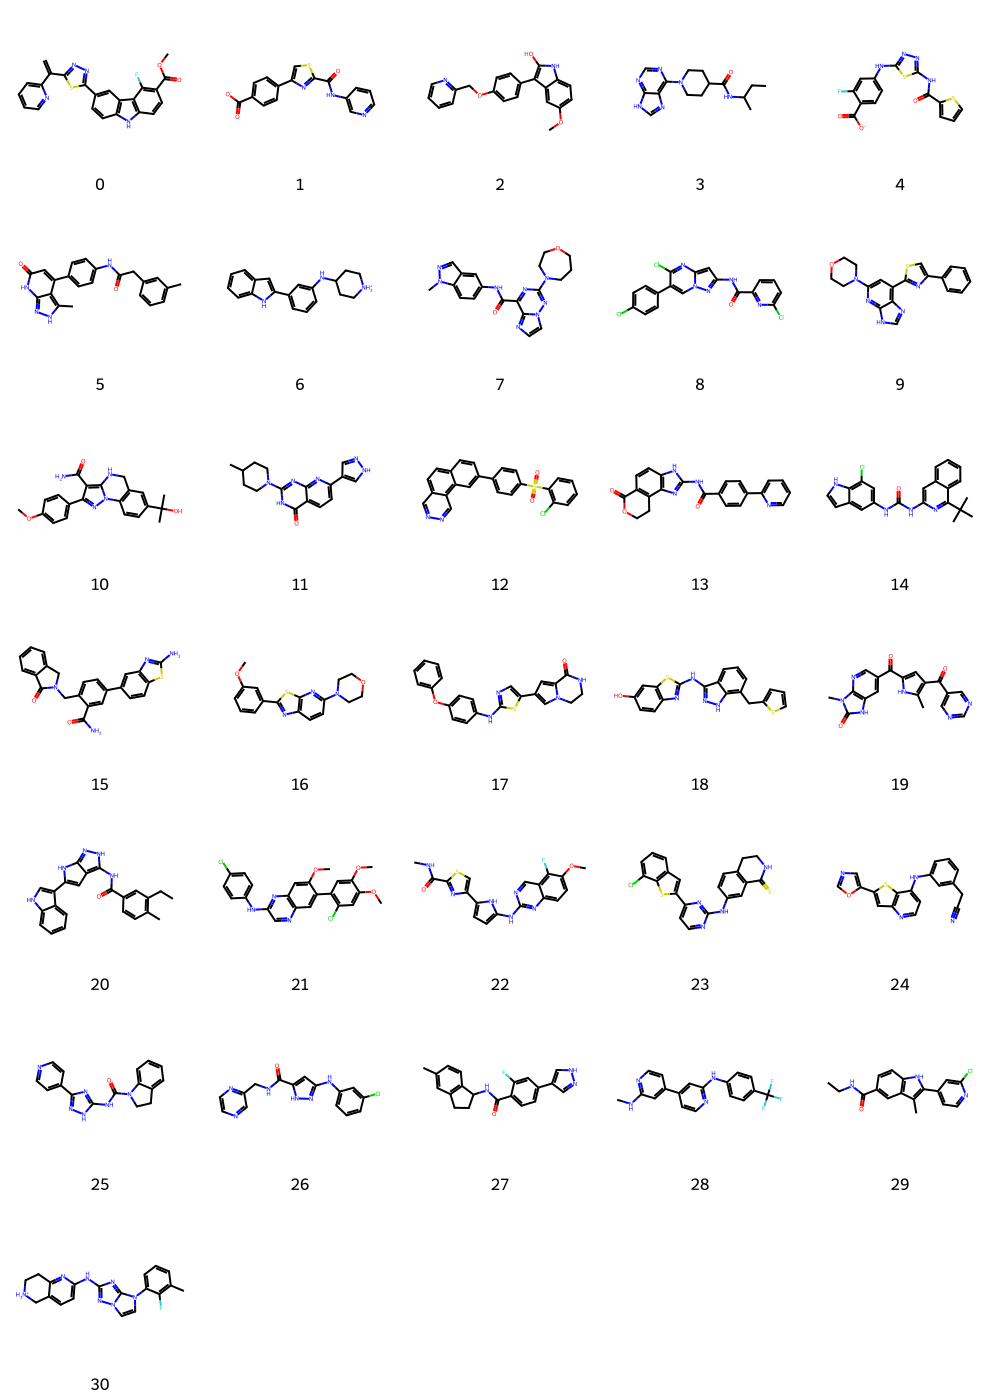

In [24]:
mols2d = [deepcopy(mol) for mol in gen_mols]
for m in mols2d: 
    m.RemoveAllConformers()
    
Chem.Draw.MolsToGridImage(mols2d, molsPerRow=5, subImgSize=(200, 200), legends=[f"{i}" for i in range(len(mols2d))], returnPNG=False)

## Inpainting, doing e.g. Fragment Replacement

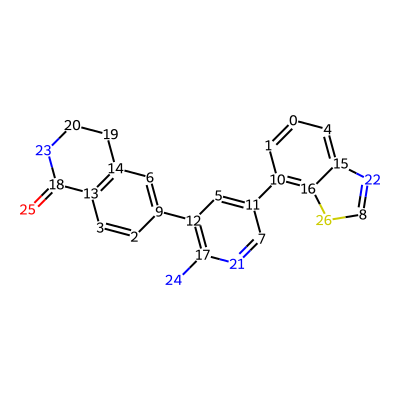

In [33]:
sdf_file = sdf_files[0]
pdb_file = pdb_files[0]

ref_mol = Chem.SDMolSupplier(str(sdf_file), sanitize=True, removeHs=True)[0]
ref_mol.RemoveAllConformers()
for prop in ref_mol.GetPropNames():
    ref_mol.ClearProp(prop)
    
show_atom_number(deepcopy(ref_mol), label="atomLabel")

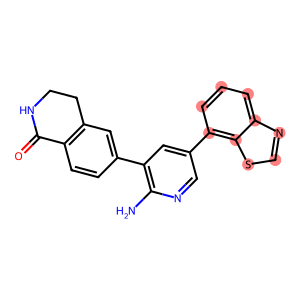

In [36]:
remove_ids = [0, 1, 10, 16, 15, 4, 22, 8, 26]
keep_ids = np.arange(ref_mol.GetNumAtoms())
keep_ids = np.setdiff1d(keep_ids, remove_ids)
anchor_idx = [11]
Chem.Draw.MolToImage(ref_mol, highlightAtoms=remove_ids)

In [28]:
do_inpainting = True

data = create_batch_from_pl_files(
                pdb_file=pdb_file,
                sdf_file=sdf_file,
                batch_size=32,
                pocket_cutoff=5.0,
                removeHs_ligand_post=True,
                removeHs_pocket_post=True,
                inpainting=do_inpainting,
                keep_ids=keep_ids,
                anchor_idx=anchor_idx,
                min_nodes_bias=0,
                max_nodes_bias=3,
            ).to(device)

gen_mols = []
num_graphs = len(data.batch.bincount())
with torch.no_grad():
    molecules, traj, cl_loss = model.model.reverse_sampling_node_level_t(
        N=100,
        device=model.device,
        pocket_data=data,
        verbose=True,
        save_traj=True,
        cat_noise=True,
        pos_noise=False,
        clash_guidance=False,
        clash_guidance_scale=0.05,
        score_dynamics=True,
        score_scale=0.5,
        dt_pow=0.5,
    )
rdmols = [m.rdkit_mol for m in molecules]
is_valid = []
for i, mol in enumerate(rdmols):
    try:
        Chem.SanitizeMol(mol)
        if check_for_disconnected_components(mol):
            is_valid.append(i)
    except: 
        pass
rdmols_valid = [rdmols[i] for i in is_valid]
gen_mols.extend(rdmols_valid)

100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


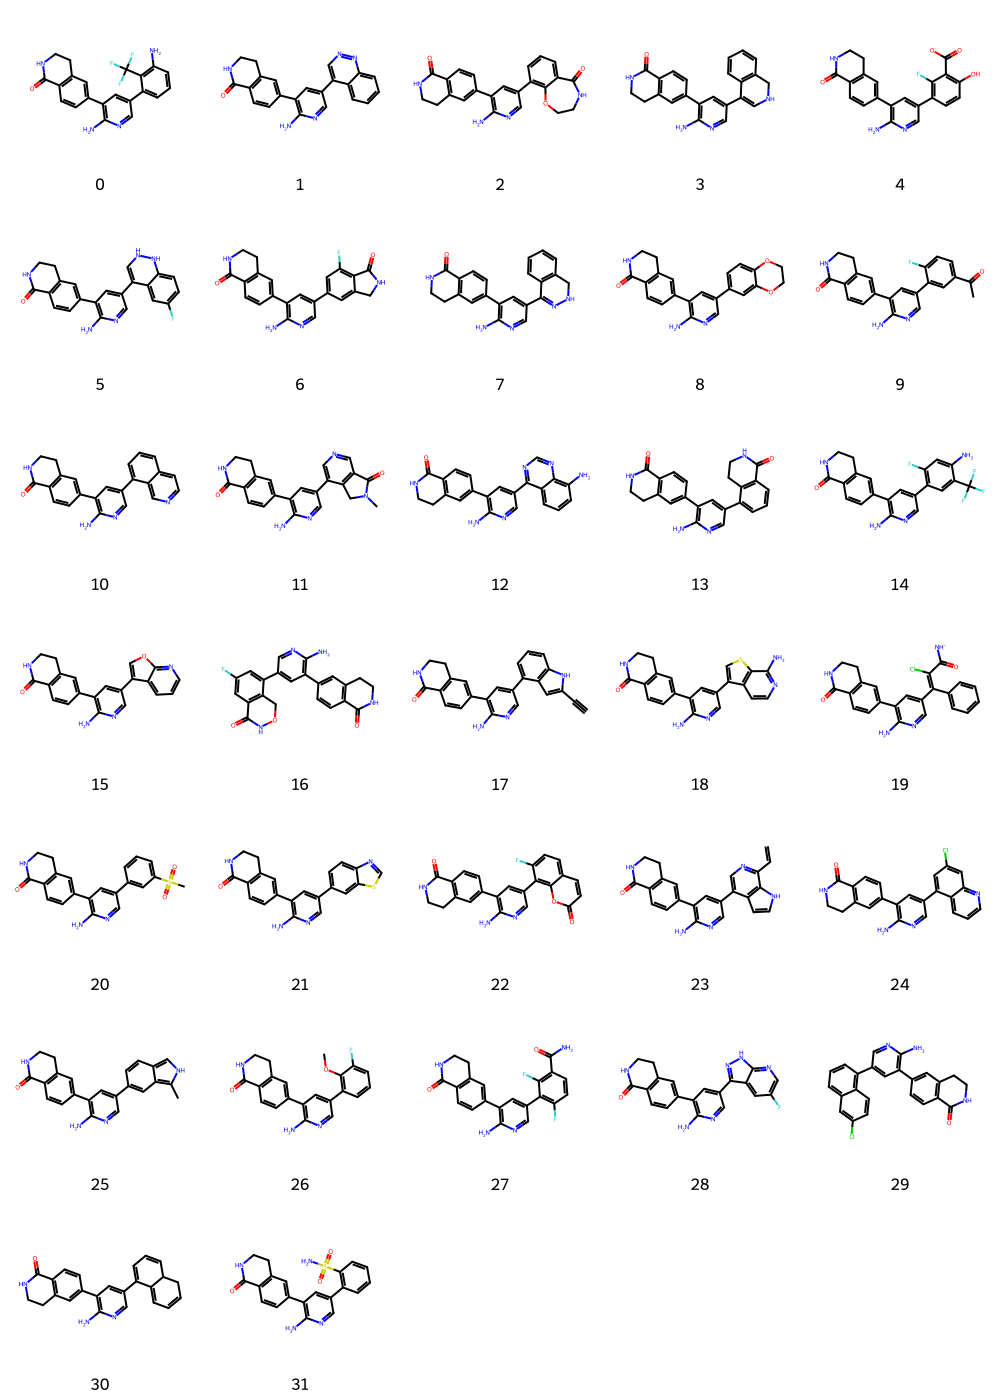

In [29]:
mols2d = [deepcopy(mol) for mol in gen_mols]
for m in mols2d: 
    m.RemoveAllConformers()
    
Chem.Draw.MolsToGridImage(mols2d, molsPerRow=5, subImgSize=(200, 200), legends=[f"{i}" for i in range(len(mols2d))], returnPNG=False)

# Overlay structures

In [30]:
visualize_multiple_3d_mols(gen_mols, align_to_first=False)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

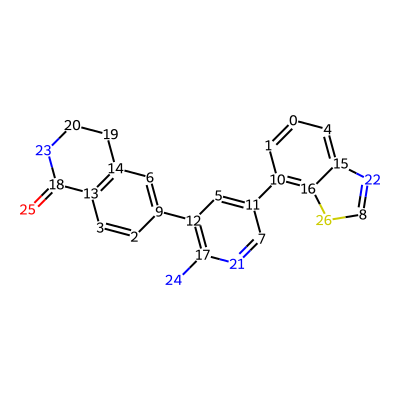

In [34]:
show_atom_number(deepcopy(ref_mol), label="atomLabel")

# Change the core

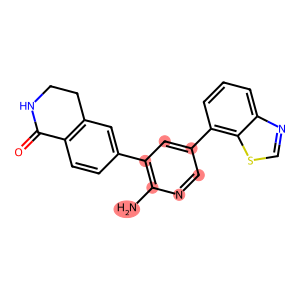

In [37]:
remove_ids = [24, 17, 21, 7, 11, 5, 12]
keep_ids = np.arange(ref_mol.GetNumAtoms())
keep_ids = np.setdiff1d(keep_ids, remove_ids)
anchor_idx = [9, 10]
Chem.Draw.MolToImage(ref_mol, highlightAtoms=remove_ids)

In [38]:
do_inpainting = True

data = create_batch_from_pl_files(
                pdb_file=pdb_file,
                sdf_file=sdf_file,
                batch_size=32,
                pocket_cutoff=5.0,
                removeHs_ligand_post=True,
                removeHs_pocket_post=True,
                inpainting=do_inpainting,
                keep_ids=keep_ids,
                anchor_idx=anchor_idx,
                min_nodes_bias=0,
                max_nodes_bias=3,
            ).to(device)

gen_mols = []
num_graphs = len(data.batch.bincount())
with torch.no_grad():
    molecules, traj, cl_loss = model.model.reverse_sampling_node_level_t(
        N=100,
        device=model.device,
        pocket_data=data,
        verbose=True,
        save_traj=True,
        cat_noise=True,
        pos_noise=False,
        clash_guidance=False,
        clash_guidance_scale=0.05,
        score_dynamics=True,
        score_scale=0.5,
        dt_pow=0.5,
    )
rdmols = [m.rdkit_mol for m in molecules]
is_valid = []
for i, mol in enumerate(rdmols):
    try:
        Chem.SanitizeMol(mol)
        if check_for_disconnected_components(mol):
            is_valid.append(i)
    except: 
        pass
rdmols_valid = [rdmols[i] for i in is_valid]
gen_mols.extend(rdmols_valid)

100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


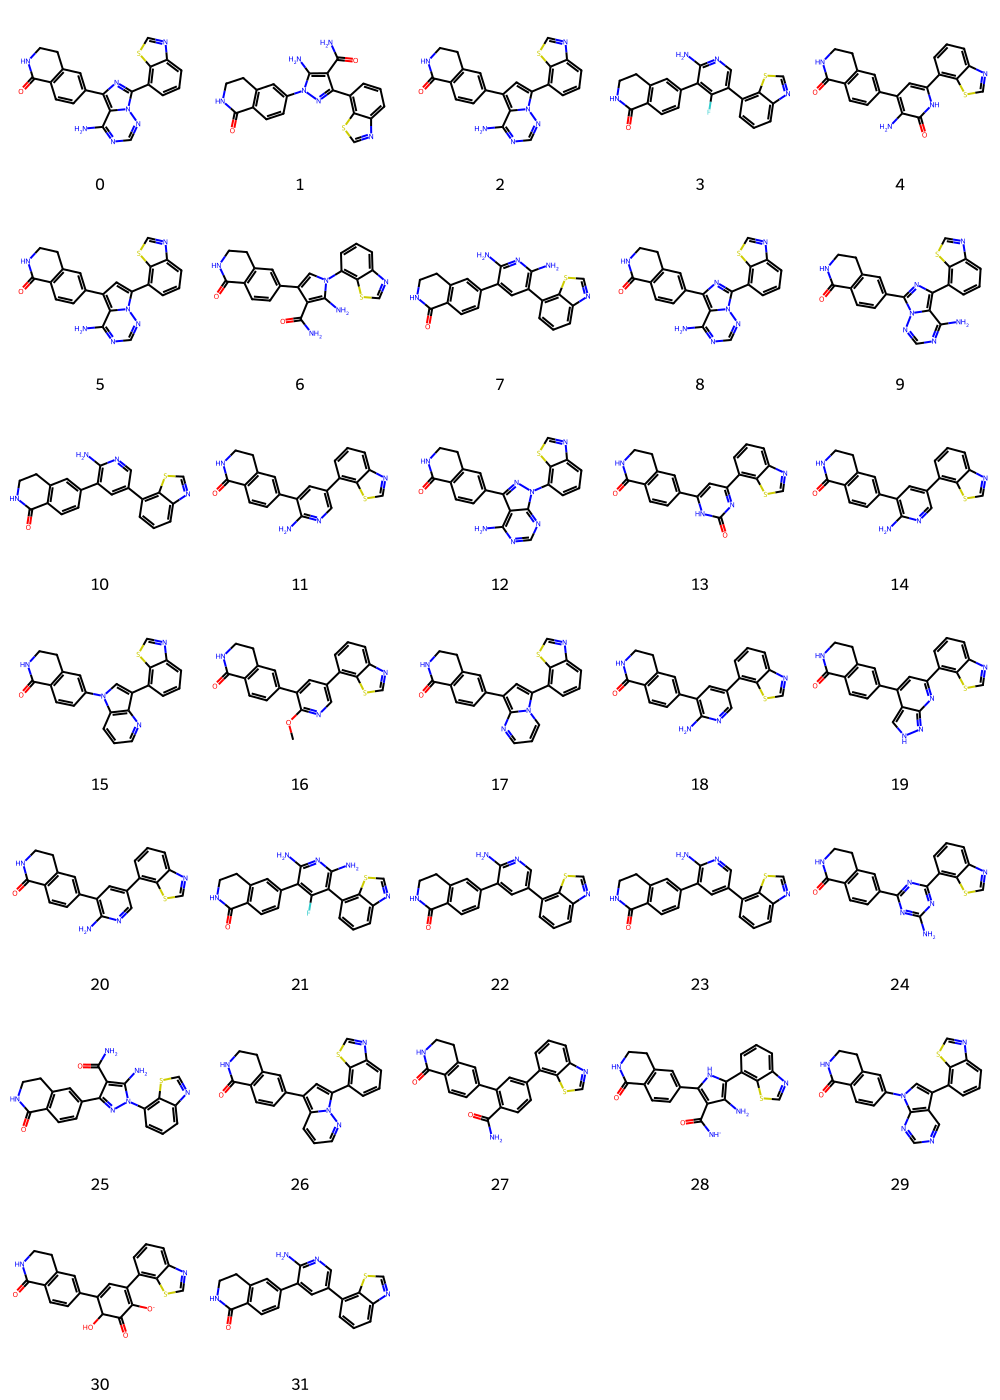

In [39]:
mols2d = [deepcopy(mol) for mol in gen_mols]
for m in mols2d: 
    m.RemoveAllConformers()
    
Chem.Draw.MolsToGridImage(mols2d, molsPerRow=5, subImgSize=(200, 200), legends=[f"{i}" for i in range(len(mols2d))], returnPNG=False)

In [40]:
visualize_multiple_3d_mols(gen_mols, align_to_first=False)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Use PILOT-Diffusion Model

In [ ]:
bp = Path("./ckpt/kinodata3d/flow/cutable/")
datapath = Path("./data/kinodata3d/")
path = bp / "best_valid.ckpt"

In [42]:
from e3mol.experiments.trainer import Trainer

model = Trainer.load_from_checkpoint(path,
                                     dataset_info=dataset_info,
                                     pocket_noise_std=hparams.pocket_noise_std,
                                     ckpt_path=None,
                                     smiles=datamodule.train_dataset.smiles,
                                    ).to(device)
model.smiles_train = datamodule.train_dataset.smiles

Using Protein-Ligand Diffusion Model


## De-Novo Generation

In [43]:
do_inpainting = False

data = create_batch_from_pl_files(
                pdb_file=pdb_file,
                sdf_file=sdf_file,
                batch_size=32,
                pocket_cutoff=5.0,
                removeHs_ligand_post=True,
                removeHs_pocket_post=True,
                inpainting=do_inpainting,
                keep_ids=None,
                anchor_idx=None,
                min_nodes_bias=0,
                max_nodes_bias=0,
            ).to(device)

num_nodes_lig = torch.randint(low=mol.GetNumHeavyAtoms() - 5,
                              high=mol.GetNumHeavyAtoms() + 5, 
                              size=(32, ),
                              device=device
                              )
gen_mols = []
num_graphs = len(data.batch.bincount())
with torch.no_grad():
    molecules, traj, cl_loss = model.model.reverse_sampling(
        num_graphs=num_graphs,
        num_nodes_lig=num_nodes_lig,
        device=model.device,
        pocket_data=data,
        verbose=True,
        save_traj=True,
        clash_guidance=False,
        clash_guidance_scale=0.05,
    )
rdmols = [m.rdkit_mol for m in molecules]
is_valid = []
for i, mol in enumerate(rdmols):
    try:
        Chem.SanitizeMol(mol)
        if check_for_disconnected_components(mol):
            is_valid.append(i)
    except: 
        pass
rdmols_valid = [rdmols[i] for i in is_valid]
gen_mols.extend(rdmols_valid)

100%|██████████| 500/500 [01:10<00:00,  7.06it/s]
[10:17:13] Explicit valence for atom # 16 C, 5, is greater than permitted
[10:17:13] Explicit valence for atom # 22 F, 2, is greater than permitted


In [44]:
view_3d(gen_mols[1])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

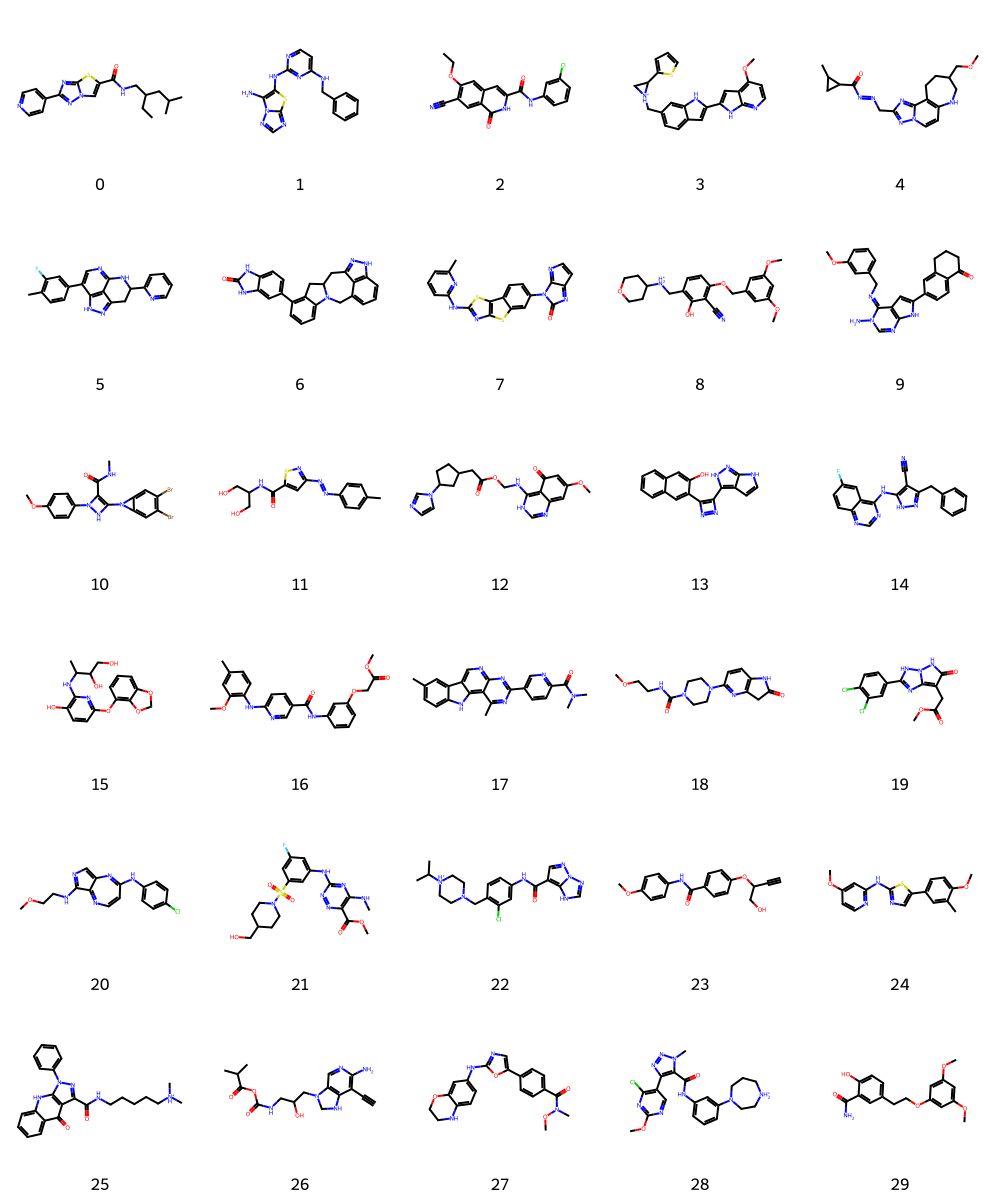

In [45]:
mols2d = [deepcopy(mol) for mol in gen_mols]
for m in mols2d: 
    m.RemoveAllConformers()
    
Chem.Draw.MolsToGridImage(mols2d, molsPerRow=5, subImgSize=(200, 200), legends=[f"{i}" for i in range(len(mols2d))], returnPNG=False)

## Inpainting, doing e.g. Fragment Replacement

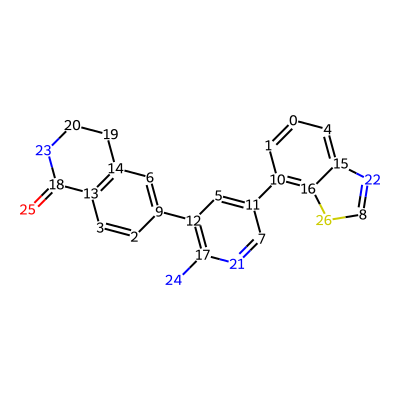

In [46]:
sdf_file = sdf_files[0]
pdb_file = pdb_files[0]

ref_mol = Chem.SDMolSupplier(str(sdf_file), sanitize=True, removeHs=True)[0]
ref_mol.RemoveAllConformers()
for prop in ref_mol.GetPropNames():
    ref_mol.ClearProp(prop)
    
show_atom_number(deepcopy(ref_mol), label="atomLabel")

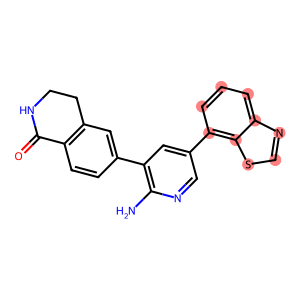

In [47]:
remove_ids = [0, 1, 10, 16, 15, 4, 22, 8, 26]
keep_ids = np.arange(ref_mol.GetNumAtoms())
keep_ids = np.setdiff1d(keep_ids, remove_ids)
anchor_idx = [11]
Chem.Draw.MolToImage(ref_mol, highlightAtoms=remove_ids)

In [48]:
do_inpainting = True

data = create_batch_from_pl_files(
                pdb_file=pdb_file,
                sdf_file=sdf_file,
                batch_size=32,
                pocket_cutoff=5.0,
                removeHs_ligand_post=True,
                removeHs_pocket_post=True,
                inpainting=do_inpainting,
                keep_ids=keep_ids,
                anchor_idx=anchor_idx,
                min_nodes_bias=0,
                max_nodes_bias=3,
            ).to(device)

gen_mols = []
num_graphs = len(data.batch.bincount())
with torch.no_grad():
    molecules, traj, cl_loss = model.model.reverse_sampling_node_level_t(
        device=model.device,
        pocket_data=data,
        verbose=True,
        save_traj=True,
        clash_guidance=False,
        clash_guidance_scale=0.05,
    )
rdmols = [m.rdkit_mol for m in molecules]
is_valid = []
for i, mol in enumerate(rdmols):
    try:
        Chem.SanitizeMol(mol)
        if check_for_disconnected_components(mol):
            is_valid.append(i)
    except: 
        pass
rdmols_valid = [rdmols[i] for i in is_valid]
gen_mols.extend(rdmols_valid)

100%|██████████| 500/500 [01:12<00:00,  6.93it/s]


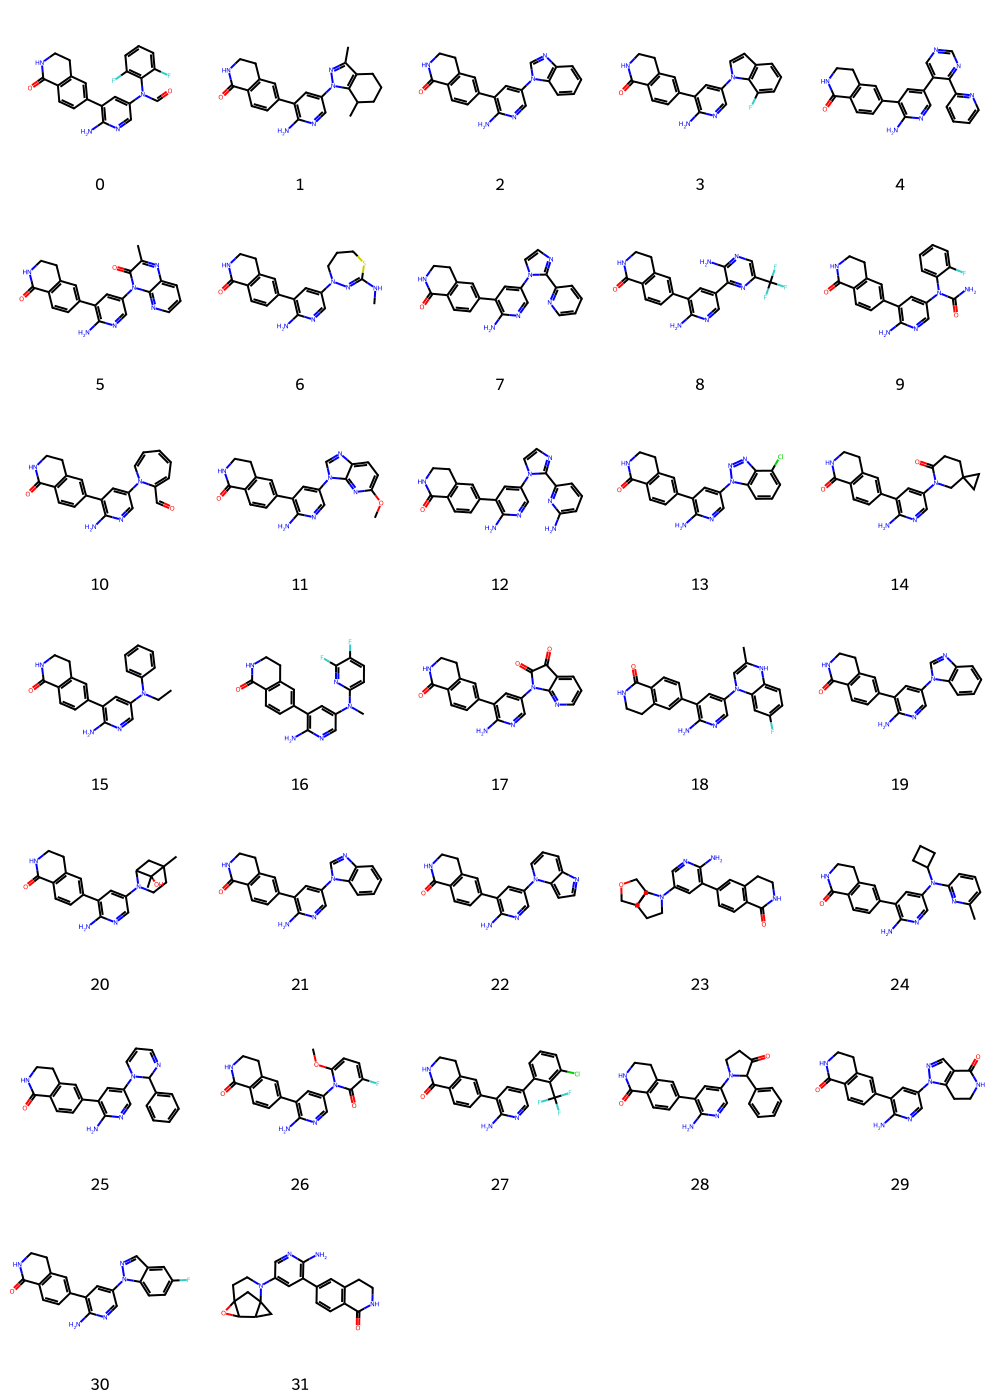

In [49]:
mols2d = [deepcopy(mol) for mol in gen_mols]
for m in mols2d: 
    m.RemoveAllConformers()
    
Chem.Draw.MolsToGridImage(mols2d, molsPerRow=5, subImgSize=(200, 200), legends=[f"{i}" for i in range(len(mols2d))], returnPNG=False)

# Overlay structures

In [50]:
visualize_multiple_3d_mols(gen_mols, align_to_first=False)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

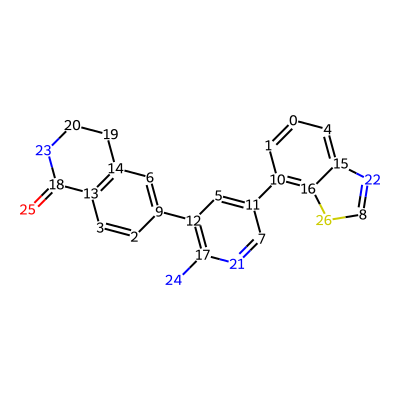

In [51]:
show_atom_number(deepcopy(ref_mol), label="atomLabel")

# Change the core

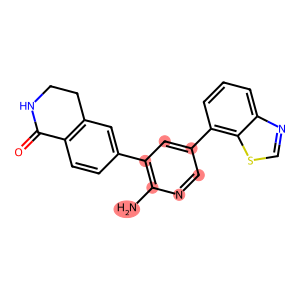

In [52]:
remove_ids = [24, 17, 21, 7, 11, 5, 12]
keep_ids = np.arange(ref_mol.GetNumAtoms())
keep_ids = np.setdiff1d(keep_ids, remove_ids)
anchor_idx = [9, 10]
Chem.Draw.MolToImage(ref_mol, highlightAtoms=remove_ids)

In [53]:
do_inpainting = True

data = create_batch_from_pl_files(
                pdb_file=pdb_file,
                sdf_file=sdf_file,
                batch_size=32,
                pocket_cutoff=5.0,
                removeHs_ligand_post=True,
                removeHs_pocket_post=True,
                inpainting=do_inpainting,
                keep_ids=keep_ids,
                anchor_idx=anchor_idx,
                min_nodes_bias=0,
                max_nodes_bias=3,
            ).to(device)

gen_mols = []
num_graphs = len(data.batch.bincount())
with torch.no_grad():
    molecules, traj, cl_loss = model.model.reverse_sampling_node_level_t(
        N=100,
        device=model.device,
        pocket_data=data,
        verbose=True,
        save_traj=True,
        clash_guidance=False,
        clash_guidance_scale=0.05,
    )
rdmols = [m.rdkit_mol for m in molecules]
is_valid = []
for i, mol in enumerate(rdmols):
    try:
        Chem.SanitizeMol(mol)
        if check_for_disconnected_components(mol):
            is_valid.append(i)
    except: 
        pass
rdmols_valid = [rdmols[i] for i in is_valid]
gen_mols.extend(rdmols_valid)

100%|██████████| 500/500 [01:12<00:00,  6.87it/s]
[10:22:12] Explicit valence for atom # 17 N, 4, is greater than permitted
[10:22:12] Explicit valence for atom # 7 N, 4, is greater than permitted
[10:22:12] Explicit valence for atom # 11 N, 4, is greater than permitted
[10:22:12] Explicit valence for atom # 12 N, 4, is greater than permitted
[10:22:12] Explicit valence for atom # 21 C, 5, is greater than permitted
[10:22:12] Explicit valence for atom # 11 N, 4, is greater than permitted


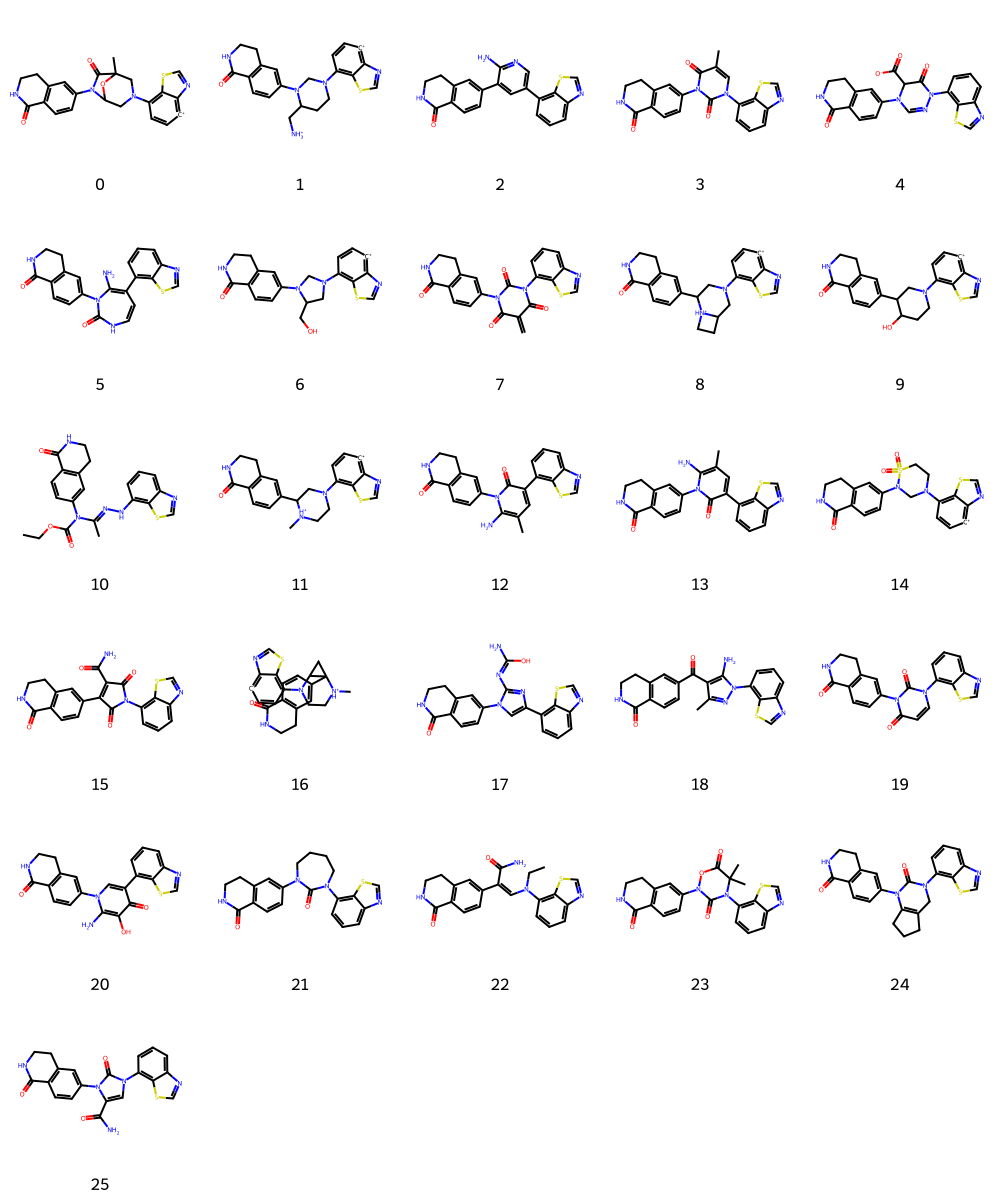

In [54]:
mols2d = [deepcopy(mol) for mol in gen_mols]
for m in mols2d: 
    m.RemoveAllConformers()
Chem.Draw.MolsToGridImage(mols2d, molsPerRow=5, subImgSize=(200, 200), legends=[f"{i}" for i in range(len(mols2d))], returnPNG=False)

In [55]:
visualize_multiple_3d_mols(gen_mols, align_to_first=False)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.